# Super Resolution GAN

# Importing the Libraries

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
from skimage.transform import resize

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[3]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4289204090578609812
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [4]:
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generator

In [6]:
def gen_residual_block(model, n_kernel=64, kernel_size=(3, 3), strides=(1, 1)):
    gen = layers.Conv2D(n_kernel, kernel_size, strides=strides, padding='same')(model)
    gen = layers.BatchNormalization()(gen)
    gen = layers.PReLU(shared_axes=[1, 2])(gen)

    gen = layers.Conv2D(n_kernel, kernel_size, strides=strides, padding='same')(gen)
    gen = layers.BatchNormalization()(gen)

    gen = layers.Add()([model, gen])

    return gen

def upsample_block(model, n_kernel=256, kernel_size=(3, 3), strides=(1, 1)):
    model = layers.Conv2D(n_kernel, kernel_size, strides=strides, padding='same')(model)
    model = layers.UpSampling2D(size=(2, 2))(model)
    model = layers.PReLU(shared_axes=[1, 2])(model)

    return model

def generator_model(input_shape, num_residual_blocks=16, upscale_factor=2):
    if upscale_factor %2 != 0:
        return None

    gen_input = tf.keras.Input(shape=input_shape)

    model = layers.Conv2D(64, (9, 9), strides=(1, 1), padding='same')(gen_input)
    model = layers.PReLU(shared_axes=[1, 2])(model)

    gen_model = model

    # residual_blocks
    for _ in range(num_residual_blocks):
        model = gen_residual_block(model)

    model = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model)
    model = layers.BatchNormalization()(model)

    model = layers.Add()([gen_model, model])

    # upsampling blocks 
    for _ in range(upscale_factor):
        model = upsample_block(model)

    model = layers.Conv2D(3, (9, 9), strides=(1, 1), padding='same')(model)
    model = layers.Activation('tanh')(model)

    generator_model = tf.keras.Model(inputs=gen_input, outputs=model, name='Generator')

    return generator_model

In [7]:
gen_input_shape = (96, 96, 3)
num_residual_blocks = 16
upscale_factor = 2
generator = generator_model(input_shape=gen_input_shape, 
                            num_residual_blocks=num_residual_blocks)

In [8]:
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 96, 96, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   36928       p_re_lu[0][0]                    
__________________________________________________________________________________________

# Discriminator

In [9]:
def discriminator_block(model, n_kernel, kernel_size, strides):
    model = layers.Conv2D(n_kernel, kernel_size, strides=strides, padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(0.2)(model)

    return model

def discriminator_model(input_shape):
    disc_input = tf.keras.Input(shape=input_shape)

    model = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(disc_input)
    model = layers.LeakyReLU(0.2)(model)

    model = discriminator_block(model, 64, (3, 3), (2, 2))
    model = discriminator_block(model, 128, (3, 3), (1, 1))
    model = discriminator_block(model, 128, (3, 3), (2, 2))
    model = discriminator_block(model, 256, (3, 3), (1, 1))
    model = discriminator_block(model, 256, (3, 3), (2, 2))
    model = discriminator_block(model, 512, (3, 3), (1, 1))
    model = discriminator_block(model, 512, (3, 3), (2, 2))

    model = layers.Flatten()(model)
    model = layers.Dense(1024)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Dense(1)(model)
    model = layers.Activation('sigmoid')(model)

    disc_model = tf.keras.Model(inputs=disc_input, outputs=model, name='Discriminator')

    return disc_model

In [10]:
disc_input_shape = (gen_input_shape[0] * (2 ** upscale_factor), gen_input_shape[1] * (2 ** upscale_factor), 3)
discriminator = discriminator_model(disc_input_shape)

In [11]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 384, 384, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 384, 384, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 192, 192, 64)      36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 192, 192, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 192, 192, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 192, 192, 128)   

# Losses
### Content Loss compares deep features extracted from high resolution images with the produced super resolution images, using a VGG-19 pretrained model

In [12]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_squared_error = tf.keras.losses.MeanSquaredError()
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(None, None, 3))
vgg_model = tf.keras.Model(vgg.input, vgg.layers[20].output)    # 20th layer of VGG-19

In [13]:
def discriminator_loss(high_res, super_res):
    high_res_loss = binary_cross_entropy(tf.ones_like(high_res), high_res)
    super_res_loss = binary_cross_entropy(tf.zeros_like(super_res), super_res)
    total_loss = high_res_loss + super_res_loss
    return total_loss

def generator_loss(super_res):
    return binary_cross_entropy(tf.ones_like(super_res), super_res)

@tf.function
def content_loss(high_res, super_res):
    high_res = tf.keras.applications.vgg19.preprocess_input(high_res)
    super_res = tf.keras.applications.vgg19.preprocess_input(super_res)

    high_res_features = vgg_model(high_res) / 12.75
    super_res_features = vgg_model(super_res) / 12.75

    return mean_squared_error(high_res_features, super_res_features)

# Training

In [14]:
lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [15]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/GANs/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#generator = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANs/generator-ckpt.h5')
#discriminator = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GANs/discriminator-ckpt.h5')

In [17]:
@tf.function
def train_step(low_res, high_res):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #print('hello')
        # forward pass
        super_res = generator(low_res, training=True)
        high_res_output = discriminator(high_res, training=True)
        super_res_output = discriminator(super_res, training=True)

        # compute loss
        con_loss = content_loss(high_res, super_res)
        gen_loss = generator_loss(super_res_output)
        disc_loss = discriminator_loss(high_res_output, super_res_output)
        perc_loss = con_loss + 0.001 * gen_loss     # from srgan paper

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update Weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset_lr, dataset_hr, epochs, test_lr):
    for epoch in range(550, epochs):
        start = time.time()

        for (lr_batch, hr_batch) in zip(dataset_lr, dataset_hr):
            train_step(lr_batch, hr_batch)

        generator.save('/content/drive/My Drive/Colab Notebooks/GANs/generator-ckpt.h5')
        discriminator.save('/content/drive/My Drive/Colab Notebooks/GANs/discriminator-ckpt.h5')

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                test_lr)

        # Save the model every 15 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            test_lr)

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig=plt.figure(figsize=(16, 16))   
    columns = 4
    rows = 1

    for i in range(predictions.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(np.uint8(predictions[i, :, :, :] * 127.5 + 127.5))

    plt.savefig('/content/drive/My Drive/Colab Notebooks/GANs/epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Datasets

In [20]:
def get_data(image_shape, Ntrain, train_directory):
    train_hr = []
    
    train_names = os.listdir(train_directory)[:Ntrain]

    count = 1
    for train_file in train_names:
        train_image = tf.keras.preprocessing.image.load_img(train_directory + '/' + train_file, target_size=image_shape[:2])
        train_image = (tf.keras.preprocessing.image.img_to_array(train_image) - 127.5) / 127.5

        train_hr.append(train_image)

        display.clear_output(wait=True)
        print('Train : ', count)
        count += 1

    train_hr = np.array(train_hr)
    np.save('/content/drive/My Drive/Colab Notebooks/GANs/srgan_np/train_hr', train_hr)

    train_lr = []

    for data in train_hr:
        train_lr.append(resize(data, gen_input_shape))

    train_lr = np.array(train_lr)

    np.save('/content/drive/My Drive/Colab Notebooks/GANs/srgan_np/train_lr', train_lr)


In [21]:
#train_directory = '/content/drive/My Drive/Colab Notebooks/GANs/coco'
#Ntrain = 900

#get_data(disc_input_shape, Ntrain, train_directory)

In [22]:
train_hr = np.load('/content/drive/My Drive/Colab Notebooks/GANs/srgan_np/train_hr.npy')
train_lr = np.load('/content/drive/My Drive/Colab Notebooks/GANs/srgan_np/train_lr.npy')

In [23]:
BATCH_SIZE = 4
EPOCHS = 600

In [24]:
train_directory = '/content/drive/My Drive/Colab Notebooks/GANs/coco'
indices_train = np.arange(train_hr.shape[0])
indices_train = np.random.shuffle(indices_train)

train_hr = train_hr[indices_train][0]
train_lr = train_lr[indices_train][0]

train_hr = tf.convert_to_tensor(train_hr[:(train_hr.shape[0]//BATCH_SIZE) * BATCH_SIZE], dtype=tf.float32)
train_lr = tf.convert_to_tensor(train_lr[:(train_lr.shape[0]//BATCH_SIZE) * BATCH_SIZE], dtype=tf.float32)

train_hr = tf.split(train_hr, num_or_size_splits=train_hr.shape[0]//BATCH_SIZE)
train_lr = tf.split(train_lr, num_or_size_splits=train_lr.shape[0]//BATCH_SIZE)

test_images_list = os.listdir(train_directory)
test_images_list = test_images_list[len(test_images_list) - 4:len(test_images_list)]

test_images = []

for i in range(4):
    test_image = tf.keras.preprocessing.image.load_img('/content/drive/My Drive/Colab Notebooks/GANs/coco/' + test_images_list[i], target_size=disc_input_shape[:2])
    test_image = (tf.keras.preprocessing.image.img_to_array(test_image) - 127.5) / 127.5
    test_image = resize(test_image, gen_input_shape)
    test_images.append(test_image)
    
test_images = tf.convert_to_tensor(np.array(test_images), dtype=tf.float32)

# Main

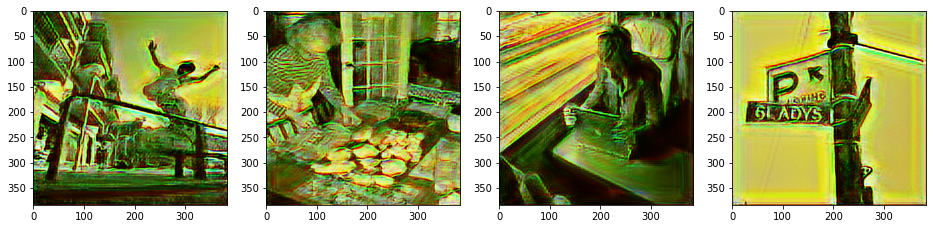

In [25]:
train(train_lr, train_hr, EPOCHS, test_images)

In [26]:
generator.save('/content/drive/My Drive/Colab Notebooks/GANs/models/srgan-generator-384x384-600.h5')
discriminator.save('/content/drive/My Drive/Colab Notebooks/GANs/models/srgan-discriminator-384x384-600.h5')